
# LDA Projection of Data (redo)
[Link to sklearn docs](http://scikit-learn.org/stable/auto_examples/decomposition/plot_pca_vs_lda.html#comparison-of-lda-and-pca-2d-projection-of-iris-dataset)

In [188]:
from sklearn.utils import resample

def resample_to_equal_class_sizes(X,y):
    df = pd.DataFrame(X)
    df['group'] = [int(i) for i in y]
    groups = []
    for v in set(df['group']):
        groups.append(df[df['group'] == v])
           
    max_length = max([len(group) for group in groups])
    print("Maximum class size is %s" %max_length)
    
    final_groups = []
    for group in groups:
        if len(group) < max_length:
            print("Class %s size is %s. Resampling with replacement to %s" %(max(group['group']),len(group), max_length))
            final_groups.append(resample(group, replace=True, n_samples=max_length))
        else:
            print("Class %s size has max class size (%s)." %(max(group['group']), max_length))
            final_groups.append(group)
    df = pd.concat(final_groups)
    return df.drop('group', axis=1).values, df['group'].values
    

#print(X_train_std.shape)
#print(y_train_group_park.shape)
#xr, yr = resample_to_equal_class_sizes(X_train_std, y_train_group_park)
#print(xr.shape, yr.shape)


In [90]:
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

def svm_grid_search(X_train, X_test, y_train, y_test, cv=5):

    tuned_parameters = [{'kernel': ['linear'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}, {'kernel': ['rbf'], 'C': [1, 10, 100, 1000], 'gamma': [1e-4, 1e-3, 1e-2, 1e-1, 1]}]

    print("# Tuning hyper-parameters for f1")
    print()

    clf = GridSearchCV(svm.SVC(), tuned_parameters, cv=cv,
                       scoring='f1_macro',
                       n_jobs = -1 )
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()
    
    return clf

In [195]:
# Read in the data
import pandas as pd

raw_data = pd.read_excel('data/training_data.xlsx')

# remove unneeded subject ID column
data = raw_data.drop('Subject', axis=1)

In [196]:
# split the X and y data
X = data.values[:,:-1]
y = data.values[:,-1]


In [197]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=44)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(596, 37)
(150, 37)
(596,)
(150,)


In [201]:
# standardize the data by removing the mean (making it 0) and scaling to unit variance
from sklearn.preprocessing import StandardScaler
std_scale = StandardScaler().fit(X_train)
X_train_std = std_scale.transform(X_train)
X_test_std = std_scale.transform(X_test)
print(X_train_std.shape)
print(X_test_std.shape)

(596, 37)
(150, 37)


In [203]:
# Train the LDA transformer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()
lda.fit(X_train_std, y_train)


LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

In [204]:
# Transform train and test data with lda model
X_train_lda = lda.transform(X_train_std)
X_test_lda = lda.transform(X_test_std)
print(X_train_lda.shape)
print(X_test_lda.shape)

(596, 3)
(150, 3)


In [205]:
print('explained variance ratio (LDA): %s'
      % str(lda.explained_variance_ratio_))


explained variance ratio (LDA): [ 0.50649967  0.33050781  0.16299252]


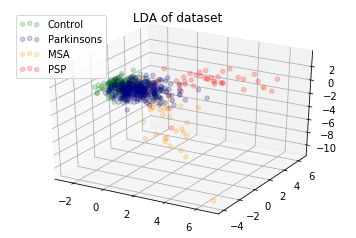

In [206]:
# Plot the LDA-transformed training data in 3d
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
colors = ['green', 'navy', 'darkorange', 'red']
target_names = ['Control', 'Parkinsons', 'MSA', 'PSP']
for color, i, target_name in zip(colors, [0, 1, 2, 3], target_names):
    ax.scatter(X_train_lda[y_train == i, 0], X_train_lda[y_train == i, 1], X_train_lda[y_train == i, 2], alpha=.2, color=color,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=3)
plt.title('LDA of dataset')

plt.show()

## Do the LDA again but group all parkinsons together

In [207]:
# LDA with all parkinsons grouped
y_train_group_park = y_train.copy()
y_test_group_park = y_test.copy()
y_train_group_park[y_train_group_park != 0] = 1
y_test_group_park[y_test_group_park != 0] = 1


In [208]:
# Resample the data
X_train_std_res, y_train_group_park_res = resample_to_equal_class_sizes(X_train_std, y_train_group_park)


Maximum class size is 408
Class 0 size is 188. Resampling with replacement to 408
Class 1 size has max class size (408).


In [209]:
# Train the LDA transformer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()
lda.fit(X_train_std_res, y_train_group_park_res)


LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

In [210]:
# Transform train and test data with lda model
X_train_lda = lda.transform(X_train_std_res)
X_test_lda = lda.transform(X_test_std)
print(X_train_lda.shape)
print(X_test_lda.shape)

(816, 1)
(150, 1)


In [211]:
print('explained variance ratio (LDA): %s'
      % str(lda.explained_variance_ratio_))


explained variance ratio (LDA): [ 1.]


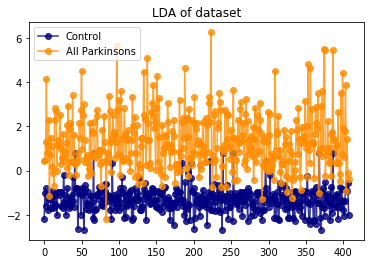

In [213]:
# Plot the LDA-transformed training data in 3d
import matplotlib.pyplot as plt
import numpy as np

plt.figure()
colors = ['navy', 'darkorange']
target_names = ['Control', 'All Parkinsons']
for color, i, target_name in zip(colors, [0, 1], target_names):
    plt.plot(X_train_lda[y_train_group_park_res == i], alpha=.8, color=color, marker='o',
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=3)
plt.title('LDA of dataset')

plt.show()


In [214]:
df= pd.DataFrame(X_train_lda)
df['GroupID'] = y_train_group_park_res
df.groupby('GroupID').mean()

,0
GroupID,
0,-1.313344
1,1.313344


### Create a model to classify control vs. parkinsons

In [216]:
clf = svm_grid_search(X_train_lda, X_test_lda, y_train_group_park_res, y_test_group_park, cv=5)

# Tuning hyper-parameters for f1

Best parameters set found on development set:

{'C': 1, 'gamma': 1, 'kernel': 'rbf'}

Grid scores on development set:

0.886 (+/-0.030) for {'C': 0.001, 'kernel': 'linear'}
0.934 (+/-0.033) for {'C': 0.01, 'kernel': 'linear'}
0.946 (+/-0.020) for {'C': 0.1, 'kernel': 'linear'}
0.947 (+/-0.017) for {'C': 1, 'kernel': 'linear'}
0.947 (+/-0.017) for {'C': 10, 'kernel': 'linear'}
0.947 (+/-0.017) for {'C': 100, 'kernel': 'linear'}
0.947 (+/-0.017) for {'C': 1000, 'kernel': 'linear'}
0.619 (+/-0.078) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.913 (+/-0.036) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.942 (+/-0.037) for {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}
0.947 (+/-0.017) for {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
0.955 (+/-0.016) for {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
0.913 (+/-0.036) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.941 (+/-0.040) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.947 (+/-0.017) for {'C': 10, 'gamma': 0.01

### See how model performs on the validation test data set

In [224]:
model = clf.best_estimator_

# read the data in and remove unnecessary columns
validation_data = pd.read_excel('./data/Validation.xlsx')
validation_data = validation_data.drop('GUID', axis=1)
validation_data = validation_data.drop('Subject', axis=1)

# sort the validation data columns in same order as training/test data
validation_data = validation_data[data.columns]

# group all parkinson's subjects together
validation_data[validation_data['GroupID'] != 0] = 1

In [240]:
# split the features and class columns
X_valid = validation_data.values[:,:-1]
y_valid = validation_data.values[:,-1]

# standarize and lda transform the data
X_valid_std = std_scale.transform(X_valid)
X_valid_lda = lda.transform(X_valid_std)

# Calculate the accuracy
print(model.score(X_valid_lda, y_valid))
model.predict(X_valid_lda)

0.12


,Age,Sex,UPDRS,aSN_FA,Caudate_FA,CC2_FA,GP_FA,LobuleVI_FA,LobuleV_FA,MCP_FA,...,pSN_FW,Putamen_FW,SCP_FW,STN_FW,Thalamus_FW,Vermis_FW,RN_FW,PPN_FW,Dentate_FW,CC1_FW
GroupID,,,,,,,,,,,,,,,,,,,,,
0.0,0.558876,0.961948,-0.926960,-0.559145,-0.183160,0.346907,-1.705707,-1.858777,-1.490252,-1.133284,...,-0.720675,-0.596673,0.378441,-0.448078,0.145255,-0.664968,-0.375079,-0.276266,-0.683778,-0.187102
1.0,-6.151196,1.307322,-1.104336,11.801549,24.110765,5.036493,17.594970,30.655333,31.426430,11.923134,...,12.007135,11.002489,6.728797,28.370817,19.631202,17.298340,17.083064,17.736178,14.475755,9.162572


## Standardized Training Data
The training data was transformed so that it has a mean of 0 and a standard deviation of 1

Since there are about twice as many Parkinsons subjects as controls, you'll notice that, for each column the '0' group value plus two times the '1' group value adds up to roughly 0 (zero mean)

In [242]:
std_test = pd.DataFrame(X_train_std)
std_test['GroupID'] = y_train_group_park
std_test.columns = data.columns
std_test.groupby('GroupID').mean()

,Age,Sex,UPDRS,aSN_FA,Caudate_FA,CC2_FA,GP_FA,LobuleVI_FA,LobuleV_FA,MCP_FA,...,pSN_FW,Putamen_FW,SCP_FW,STN_FW,Thalamus_FW,Vermis_FW,RN_FW,PPN_FW,Dentate_FW,CC1_FW
GroupID,,,,,,,,,,,,,,,,,,,,,
0.0,-0.128257,0.238132,-0.987078,-0.091946,-0.036864,-0.094802,-0.208258,-0.018447,-0.059595,-0.030858,...,-0.273459,-0.120259,-0.133106,-0.147819,-0.076018,-0.051378,-0.167610,-0.037704,-0.180749,0.076419
1.0,0.059099,-0.109728,0.454830,0.042367,0.016986,0.043683,0.095962,0.008500,0.027460,0.014219,...,0.126006,0.055414,0.061333,0.068113,0.035028,0.023674,0.077232,0.017374,0.083286,-0.035213


## Standardized Testing Data
The training data was transformed using the transformation that was created from the training data.

You would expect that the sum of the '0' and '1' groups are on the same scale as the standardized training data and that they roughly add up to 0

In [244]:
std_test = pd.DataFrame(X_test_std)
std_test['GroupID'] = y_test_group_park
std_test.columns = data.columns
std_test.groupby('GroupID').mean()

,Age,Sex,UPDRS,aSN_FA,Caudate_FA,CC2_FA,GP_FA,LobuleVI_FA,LobuleV_FA,MCP_FA,...,pSN_FW,Putamen_FW,SCP_FW,STN_FW,Thalamus_FW,Vermis_FW,RN_FW,PPN_FW,Dentate_FW,CC1_FW
GroupID,,,,,,,,,,,,,,,,,,,,,
0.0,-0.135526,0.470454,-1.014842,-0.249586,-0.091519,0.100461,-0.380776,-0.151986,-0.072399,0.108474,...,-0.468177,-0.35608,-0.185608,-0.231447,-0.248312,-0.065217,-0.338186,-0.218167,-0.294305,-0.104613
1.0,0.006189,-0.088271,0.414253,-0.085534,0.002043,0.060851,0.021291,0.012316,0.081712,0.045637,...,-0.039950,-0.03296,-0.070061,-0.077370,-0.141662,-0.039339,-0.097423,-0.098932,-0.044187,-0.074630


## Standardized Validation Data
The validation data was also transformed using the transformation that was created from the training data.

You would expect that the sum of the '0' and '1' groups are on the same scale as the standardized training data and that they roughly add up to 0

The values seen here are VERY far from 0, particularly in the parkinsons subjects

In [243]:


std_valid = pd.DataFrame(X_valid_std)
std_valid['GroupID'] = y_valid
std_valid.columns = data.columns
std_valid.groupby('GroupID').mean()

,Age,Sex,UPDRS,aSN_FA,Caudate_FA,CC2_FA,GP_FA,LobuleVI_FA,LobuleV_FA,MCP_FA,...,pSN_FW,Putamen_FW,SCP_FW,STN_FW,Thalamus_FW,Vermis_FW,RN_FW,PPN_FW,Dentate_FW,CC1_FW
GroupID,,,,,,,,,,,,,,,,,,,,,
0.0,0.558876,0.961948,-0.926960,-0.559145,-0.183160,0.346907,-1.705707,-1.858777,-1.490252,-1.133284,...,-0.720675,-0.596673,0.378441,-0.448078,0.145255,-0.664968,-0.375079,-0.276266,-0.683778,-0.187102
1.0,-6.151196,1.307322,-1.104336,11.801549,24.110765,5.036493,17.594970,30.655333,31.426430,11.923134,...,12.007135,11.002489,6.728797,28.370817,19.631202,17.298340,17.083064,17.736178,14.475755,9.162572


In [37]:
# Transform train and test data with lda model
X_train_lda = lda.transform(X_train_std)
X_test_lda = lda.transform(X_test_std)
print(X_train_lda.shape)
print(X_test_lda.shape)

(596, 3)
(150, 3)


In [38]:
print('explained variance ratio (LDA): %s'
      % str(lda.explained_variance_ratio_))


explained variance ratio (LDA): [ 0.50649967  0.33050781  0.16299252]


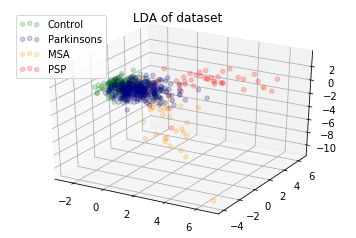

In [34]:
# Plot the LDA-transformed training data in 3d
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
colors = ['green', 'navy', 'darkorange', 'red']
target_names = ['Control', 'Parkinsons', 'MSA', 'PSP']
for color, i, target_name in zip(colors, [0, 1, 2, 3], target_names):
    ax.scatter(X_train_lda[y_train == i, 0], X_train_lda[y_train == i, 1], X_train_lda[y_train == i, 2], alpha=.2, color=color,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=3)
plt.title('LDA of dataset')

plt.show()

### Plot the validation data on the LDA plot

<IPython.core.display.Javascript object>


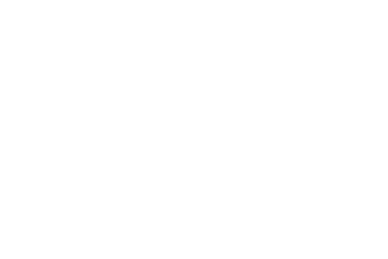

<IPython.core.display.Javascript object>


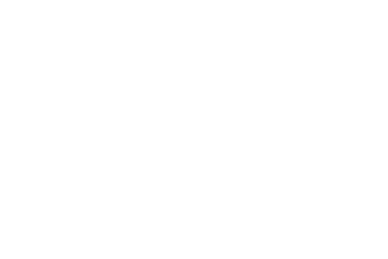

In [45]:
%matplotlib notebook

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

colors = ['lightgreen', 'turquoise', 'yellow', 'pink']
for color, i, target_name in zip(colors, [0, 1, 2, 3], target_names):
    ax.scatter(X_train_lda[y_train == i, 0], X_train_lda[y_train == i, 1], X_train_lda[y_train == i, 2], alpha=1, color=color,
                label=target_name, marker='^', s=10)
plt.legend(loc='best', shadow=False, scatterpoints=3)
plt.title('LDA of dataset')

# plot Validation data
new_colors = ['darkgreen', 'navy', 'darkorange', 'red']
for color, i, target_name in zip(new_colors, [0, 1, 2, 3], target_names):
    ax.scatter(X_valid_lda[y_valid == i, 0], X_valid_lda[y_valid == i, 1], X_valid_lda[y_valid == i, 2], alpha=1, color=color,
                label=target_name, marker='o', s=20)



plt.show()

In [46]:
means_train = data.groupby('GroupID').mean()
means_valid = validation_data.groupby('GroupID').mean()

In [47]:
means_train

,Age,Sex,UPDRS,aSN_FA,Caudate_FA,CC2_FA,GP_FA,LobuleVI_FA,LobuleV_FA,MCP_FA,...,pSN_FW,Putamen_FW,SCP_FW,STN_FW,Thalamus_FW,Vermis_FW,RN_FW,PPN_FW,Dentate_FW,CC1_FW
GroupID,,,,,,,,,,,,,,,,,,,,,
0,63.366667,0.508333,3.299583,0.658426,0.214429,0.737095,0.322795,0.239803,0.244544,0.636795,...,0.180413,0.172144,0.356283,0.115177,0.146802,0.185291,0.101717,0.120458,0.179685,0.295724
1,64.238095,0.298246,30.086466,0.662097,0.220929,0.747541,0.335253,0.242854,0.248429,0.641929,...,0.195634,0.173250,0.342426,0.115427,0.142557,0.181386,0.102993,0.119083,0.177476,0.281892
2,66.615385,0.442308,48.607692,0.650274,0.210970,0.733988,0.337108,0.234036,0.247070,0.606783,...,0.214691,0.258022,0.450237,0.124866,0.170775,0.220001,0.130292,0.124918,0.258338,0.288187
3,71.000000,0.345455,40.007273,0.677361,0.189328,0.711547,0.333134,0.236017,0.236119,0.633809,...,0.288166,0.225824,0.523387,0.162933,0.200316,0.209242,0.183980,0.158763,0.257027,0.346361


In [48]:
means_valid

,Age,Sex,UPDRS,aSN_FA,Caudate_FA,CC2_FA,GP_FA,LobuleVI_FA,LobuleV_FA,MCP_FA,...,pSN_FW,Putamen_FW,SCP_FW,STN_FW,Thalamus_FW,Vermis_FW,RN_FW,PPN_FW,Dentate_FW,CC1_FW
GroupID,,,,,,,,,,,,,,,,,,,,,
0,70.50000,0.833333,4.666667,0.646025,0.210057,0.757729,0.267373,0.194953,0.210287,0.602295,...,0.153475,0.140633,0.405257,0.106429,0.157977,0.156623,0.092857,0.110609,0.152952,0.278413
1,64.65625,0.375000,33.375000,0.637834,0.213922,0.743883,0.274059,0.204833,0.211652,0.607521,...,0.155094,0.118085,0.370541,0.096439,0.142413,0.156721,0.092188,0.091013,0.143529,0.319089
2,65.00000,0.250000,77.250000,0.633123,0.199634,0.704999,0.303082,0.205272,0.207698,0.599120,...,0.163118,0.172743,0.477533,0.098133,0.151898,0.210019,0.105418,0.106276,0.232961,0.372804
3,72.37500,0.625000,57.125000,0.639363,0.219810,0.744538,0.272502,0.196259,0.190131,0.624993,...,0.216328,0.125427,0.562548,0.159022,0.182290,0.166998,0.173218,0.159255,0.190739,0.430600


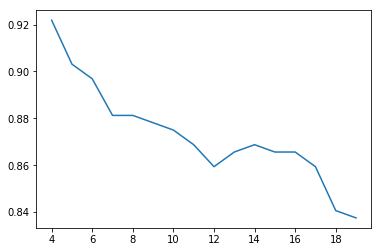

In [67]:
%matplotlib inline
from sklearn.neighbors import KNeighborsClassifier

ns = range(4,20)
scores_knn = []

for n in ns:
    neigh = KNeighborsClassifier(n_neighbors=n)
    neigh.fit(X_train_lda, y_train)
    scores_knn.append(neigh.score(X_test_lda, y_test))
    
plt.plot(ns, scores_knn)
plt.show()

In [68]:
neigh = KNeighborsClassifier(n_neighbors=4)
neigh.fit(X_train_lda, y_train)
neigh.score(X_test_lda, y_test)

0.921875

In [69]:
neigh.score(X_valid_lda, y_valid)

0.7

In [70]:
y_valid

array([0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 2., 2., 2., 2., 3., 3., 3., 3., 3., 3., 3., 3.])

In [71]:
neigh.predict(X_valid_lda)

array([0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0.,
       1., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1.,
       1., 0., 1., 1., 2., 1., 1., 1., 1., 1., 1., 3., 3., 3., 3., 1.])